# 模型选择: 以最优子集回归为例

## 1. 模型选择的标准或者模型评价准则

### 1.1 两类算法

在机器学习算法中有两类算法：有监督学习算法和无监督学习算法.

- 有监督学习是基于训练数据$\mathcal L = (X, Y)$, 使用某个算法建立
通过$\mathbf x$预测$y$, 或者对$y$分类的模型.
    
    - 如果$y$是连续性变量, 有监督学习问题即预测或者回归问题, 如果$y$是分类变量, 有监督学习问题是分类问题.
    
    - 这里, $\mathbf x=(x_1,\dots,x_p)^{T}$是$p$维自变量, 或者输入变量集, $X$是$\mathbf x$的$n$个观测组成的$n\times p$维矩阵.
    - $Y$是自变量, 或者输出变量$y$的$n$个观测组成的$n$维向量矩阵, 当然也可以是$n\times 1$维矩阵.

- 无监督学习中只有变量集$\mathbf x,$ 无目标变量$y,$ 是基于观察数据$X$, 使用某个算法寻找变量集$\mathbf x,$ 或者观测个体的内在关系或者结构, 例如聚类分析或者主成分分析.


### 1.2 模型选择准则: 模型的预测效果

本课程中不区分建模方法和算法. 有些算法非常简单, 有些算法则相对复杂. 
- 例如在回归问题中, 如果你认为所有的自变量都应该在模型中, 那就可最小二乘算法计算全模型; 
- 最优子集回归算法则认为$p$个自变量中会有冗余变量, 用最小二乘算法得到了$2^p$个模型.

无论上面的那种情况, 你都需要评价模型.
- 用最小二乘算法得到的全模型好吗?
- 最优子集回归算法得到$2^p$个模型, 需要选择出“最优”的那个模型, 那么“最优”模型的标准是什么?

本讲将以回归问题为例, 讨论算法中的模型评价问题. 既然是评价, 那么有个问题至关重要: 什么是标准? 我们首先给出模型选择的标准.

Breiman(2001)对传统数据建模中的诸多做法做了很深刻的反思, 并提出几个影响深远的观点, 其中之一即"应该用模型的预测效果作为模型选择或者验证的标准", 当然这并不是Leo Breiman的首倡.

### 测试误差

你可能会认为模型的预测效果可以通过测试误差(Test Error)来评价, 其定义为
\begin{equation}
\mathrm{Err}_{\mathcal{T}}= \mathrm{E}_{\mathbf x, y}(L(\mathbf{y}, \hat{f}(\mathbf x))| \mathcal{T}),
\end{equation}
    
- 测试误差也称作推广误差(Generalized Error, 有人也译作泛化误差).
模型的预测误差又被称为测试误差(Test Error)和期望测试误差(Expected Test Error).
本课程沿用了Hastie, et al. (2009)的名称. 
    
    - 上式中, $L(\cdot)$是损失函数, $\mathcal{T}$是训练集,
$\hat{f}(x)$是通过训练集$\mathcal{T}$, 建立的对真实模型$f(\mathbf x)$的近似. 在回归问题中, 损失函数一般选择平方损失函数.

    - 测试误差是个理论指标, 一般通过测试集估计, 这里就不给出其公式了, 相信大家可以自己写出.

    - 测试误差用来评价模型会有缺点：测试误差会出现小于训练训练误差的情况.
    
- 模拟案例分析
  
    - 模型为
  $$y = 1 + x_1 + x_2 + x_3 + x_4 + \epsilon$$
  其中: $\mathrm{x} = (x_1,\dots,x_4)^{\mathrm{T}},$ 其服从均值为0, 协方差为$\Sigma$的正态分布, $\Sigma$的第$i$行第$j$列元素$\rho^{|i-j|}$, $i=1,\dots,4,$ $j=1,\dots,4$; $\epsilon$服从标准正态分布

    - 训练集n_train = 1000
    
    - 测试集n_test = 1000
    
    - 如果$Z\sim N(0,I),$ $X=LZ,$ 那么, $X \sim N(0,LL^{\mathrm{T}}).$



In [24]:
# x = norm.rvs(size=(n, p))
# x = np.dot(x, uper_mat)
import numpy as np
from scipy.stats import norm
from scipy import linalg
np.set_printoptions(precision=4, suppress=True)

In [25]:
def sigma_mat(p, rho):
    sigma = np.ones((p, p))
    for i in range(p - 1):
        sigma[range(p - i - 1), range(i + 1, p)] = rho ** (i + 1)
        sigma[range(i + 1, p), range(p - i - 1)] = rho ** (i + 1)
    return sigma
print(sigma_mat(5, 0.9))

[[1.     0.9    0.81   0.729  0.6561]
 [0.9    1.     0.9    0.81   0.729 ]
 [0.81   0.9    1.     0.9    0.81  ]
 [0.729  0.81   0.9    1.     0.9   ]
 [0.6561 0.729  0.81   0.9    1.    ]]


In [2]:
p = 5
i = 0
list(range(p - i - 1)), list(range(i + 1, p))

([0, 1, 2, 3], [1, 2, 3, 4])

In [5]:
def sim(n, p, rho, beta_0, beta_1):
    var = sigma_mat(p, rho)
    uper_mat = linalg.cholesky(var)
    x = norm.rvs(size=(n, p))
    x = np.dot(x, uper_mat)
    y = beta_0 + np.dot(x, beta_1) + norm.rvs(size=n)
    return x, y

In [6]:
def ols(x, y):
    n, _ = np.shape(x)
    x_mean = x.mean(axis=0)
    y_mean = y.mean()
    xt = x.T
    xx = np.dot(xt, x)
    xy = np.dot(xt, y)
    xx_center = xx - n * np.outer(x_mean, x_mean)
    xy_center = xy - n * y_mean * x_mean
    L = linalg.cholesky(xx_center)
    beta_1, _ = linalg.lapack.dpotrs(L, xy_center)
    beta_0 = y_mean - np.inner(beta_1, x_mean)
    return beta_0, beta_1

In [12]:
# random.seed(111)
p = 4
n_train, n_test = 50, 1000
rho = 0.5
beta_0 = 1
beta_1 = np.ones(p)

def TestandTrain_Err(n_train = n_train, n_test=n_test, 
                     p=p, rho=rho, 
                     beta_0=beta_0, beta_1=beta_1):
    x_train, y_train = sim(n_train, p, rho, beta_0, beta_1)
    x_test, y_test = sim(n_test, p, rho, beta_0, beta_1)
    b_0, b_1 = ols(x_train, y_train)
    y_pred_train = np.dot(x_train, b_1) + b_0
    y_pred_test = np.dot(x_test, b_1) + b_0
    train_err = y_pred_train - y_train
    Train_Err = np.mean(train_err * train_err)
    test_err = y_pred_test - y_test
    Test_Err = np.mean(test_err * test_err)
    return Test_Err, Train_Err
re = [TestandTrain_Err(n_train, n_test, p, rho, beta_0, beta_1) 
      for _ in np.arange(10000)]
re = np.array(re).T
print(np.mean(re[0] - re[1] <=0))
print(np.mean(re[0] - re[1]))
print(np.mean(re[1]))

0.1522
0.2136337914168675
0.900067972397754


In [13]:
print(np.std(re[0]))

0.09219438973711754


假定的模型是一个有4个自变量的模型, 训练集和测试集的样本量都是1000, 另外, 在每次
模拟中, 自变量的观测是固定的. 最后的模拟结果显示, 大约44%的模拟中, 训练集误差是小于测试集误差的;
而测试集误差与训练集误差的平均则是大于0的. 

很自然地, 考虑用测试误差的期望来衡量模型的预测效果
更经得起检验, 具体地,
期望测试误差为
\begin{equation}
\mathrm{Err}= \mathrm{E}_{\mathcal T}(\mathrm{Err}_{\mathcal{T}}).
\end{equation}
事实上期望测试误差是对模型“稳定性”的考虑, 如果换一个训练数据, 得到大相径庭的结果, 那么这个模型可信吗?

## 2. 模型评价指标

### 2.1 $C_p$和AIC

$y_i = x_i^T \beta + \epsilon_i$

Hastie, et al. (2009)定义了这样一个类似测试误差的指标: “样本内”(in-sample)测试误差
\begin{equation}
\mathrm{Err_{in}} = \frac 1 n \sum_{i=1}^n \mathrm{E}_{y_i^*}\left[(y_i^*- \hat{y}_i| Y\right]^{2},
\end{equation}
其中, $y_i^*$是在相同的模型设定下, 区别于训练集中$y_i$的另一随机实现,
$\hat{y}_i$是第$i$个样本的拟合值.
之所以称$\mathrm{Err_{in}}$为“样本内”(in-sample)期望测试误差, 是因为它是基于样本中自变量$\mathbf x$的实现$X$构造的测试误差.
事实上, 如果自变量$\mathrm x$是随机变量, 当$X$的代表性足够好时, $\mathrm{Err_{in}}$就是测试误差.

- 很自然, 我们可以用的期望“样本内”(in-sample)测试误差代替期望测试误差, 而且还有下面的分解.
\begin{equation}
\mathrm{E}_{Y}(\mathrm{Err_{in}}) = \mathrm{E}_{Y} (\mathrm{err})
+\frac 2 n \sum_{i=1}^ n \mathrm{Cov}(y_i, \hat{y}_i),
\end{equation}
其中,
\begin{equation}
\mathrm{err} = \frac 1 n \sum_{i=1}^n (y_i- \hat{f}(\mathrm x_i))^2,
\end{equation}
$\hat{y}_i=\hat{f}(\mathbf x_i).$
上式等号右边的两项也是此消彼长的关系, 模型拟合效果越好, 也就是$\mathbf{E}_{Y} (\mathrm{err})$越小.

自然$\sum_{i=1}^ n \mathrm{Cov}(y_i, \hat{y}_i)$就越大.

记$\hat{Y}=(\hat{f}(\mathbf x_1),\dots,\hat{f}(\mathbf x_n))^T,$ 假定$\hat{ Y}=S Y$(线性拟合),
那么,
$$\sum_{i=1}^ n \mathrm{Cov}(y_i, \hat{y}_i) = \mathrm{trac}(S)\sigma^2.$$
对于线性回归模型, $\mathrm{trac}(S)=d,$ $d$是线性模型系数的个数(含截距项).
于是, 上式为
\begin{equation}
\mathrm{E}_{Y}(\mathrm{Err_{in}}) = \mathrm{E}_{ Y} (\mathrm{err})
+\frac 2 n d\sigma^2,
\end{equation}

如果用$\mathrm{err}$估计$\mathrm{E}_{ Y} (\mathrm{err}),$
使用全模型得到$\sigma^2$的无偏估计$\hat{\sigma}^2,$ 就可以得到
$\mathrm{E}_{Y}(\mathrm{Err_{in}})$的估计, 也就是$C_p$统计量
\begin{equation}
C_p =  \mathrm{err} +\frac 2 n d \hat{\sigma}^2.
\end{equation}

很显然, $\mathrm{err}$越小, $d$就越大.
用上式解释“过拟合”或许更加贴切, 以最优子集回归为例, 随着自变量个数$d$的增加,
当$\mathrm{err}$的减小量不能抵消$d$的增大带来的“坏处”时, $C_p$统计量就开始变大了.
所以, “过拟合”其实是过于看重拟合效果, 导致模型的预测效果变差了.

- 在普通回归中, 还有类似的指标AIC
\begin{equation}
\mathrm{AIC}=n\log RSS +2p +\mathrm{constant},
\end{equation}
其中RSS为残差平方和

### 2.2 交叉验证

- 把数据分成$K$折.
- 依次去掉第$k$折数据, 训练出模型, 给出在第$k$折数据的预测值, $k=1,\dots,K$
- 构建$K$折交叉验证误差
$$ \frac 1 n  \sum_{k=1}^K \sum_{i=1}^{n_k} \left(y_{ki} - \hat{y}_{ki}^{(-k)}\right)^2$$
- $K$一般取值为10

## 3. 模型评价, 以最优子集回归为例

### 3.1 什么是最优子集回归
当我们进行回归分析时，我们可能会碰到自变量过多, 且存在多重共线性, 或者全模型可能是过度拟合的.
- 针对这种情况，可以人为根据经验判断筛选对因变量有影响的自变量，比如距离周边学校的距离去预测房价.
- 但通常我们并不是相关领域的专家, 对可能影响因变量的自变量并不了解，于是我们需要运用算法获得预测效果最优的模型, 进而接近真实模型，比如最优子集回归.
- 最优子集回归, 即对$p$个预测变量的所有可能组合分别使用最小二乘回归进行拟合.
- 具体地, 对含1变量的模型，拟合$p$个模型; 对含两个变量的模型，拟合$p(p-1)/2$个模型，以此类推，总共拟合$2^p-1$个模型.
- 按照一定的比较准则（如AIC）从中选择一个最优模型.

### 3.2 如何利用ols(x, y)编写最优子集回归
#### 使用整数的二进制表达
  - 记ind是一个长度为p的一维数组, 其元素为bool型, True表示相应位置变量被选入模型, False表示相应位置变量未被选入模型. 这里的一维数组共记$2^p-1$个. 例如, 当p=3时, 我们用[0, 1, 2]给变量编号, [True, False, True]表示0号和2号变量被选入模型, 而1号变量不在模型中. 
  
  - 于是, ols(x[:, ind], y), 或者solve_sym(xtx[ix_(ind, ind)], xty[ind])可以计算相应的模型.
  - 生成所有可能的ind, 存放于可迭代对象inds, 则[ols(x[:, ind], y) for ind in inds]就是所有结果.
  
  对于$i \in \{1, \dots, 2^p-1\},$ 以下关系成立,
  $$i=k_02^0+k_12^1+k_22^2+...+k_{p-1}2^{p-1}.$$
其中, $k_0, k_1,..., k_{p-1}$取值为0或者1, 即可将十进制的$i$转化为其二进制。

记$k_{b,j}$为$k_j$对应的bool型取值. 那么, 一维数组$[k_{b,0}, k_{b,1}, \dots, k_{b,p-1}]$就是理想的ind.

- <font face="黑体"> turnbits</font>函数即可实现此功能。


In [15]:
import numpy as np
##turnbits函数用于将十进制转化为p维二进制向量
##参数n为十进制数，p为二进制向量维数
##输出p维逻辑行向量
def turnbits(n, p):
    """
    用于将一个整数 n 转换为一个长度为 p 的布尔值数组，表示 n 的二进制表示形式。
    这个函数使用了循环和取余操作来实现这一转换。
    """
    z = np.zeros(p)
    z[0] = n % 2
    for j in np.arange(1, p):
        n = ( n - z[j-1] ) / 2
        if n==0:
            break
        z[j] = n % 2
    return z.astype(bool)    
print(turnbits(5, 3))
Z = np.array([turnbits(n, 3) for n in range(1, 2**3)])
Z

[ True False  True]


array([[ True, False, False],
       [False,  True, False],
       [ True,  True, False],
       [False, False,  True],
       [ True, False,  True],
       [False,  True,  True],
       [ True,  True,  True]])

除了解方程外，我们还可以使用递推公式获得矩阵$Z$
$$
\begin{array}{ccl}
 & p=1 & \\
\begin{array}{c}1
\end{array}
& 
\left[\begin{array}{cc}
1
\end{array}\right]
&
\Rightarrow\quad
\end{array} 
\begin{array}{ccl}
 & p=2 & \\
\begin{array}{c}1\\2\\3\end{array}
&
\left[\begin{array}{cc}
0&1\\
1&0\\
1&1
\end{array}\right]
&
\Rightarrow\quad
\end{array}
\begin{array}{ccl}
 & p=3 & \\
\begin{array}{c}1\\2\\4\\6\\3\\5\\7\end{array}&
\left[\begin{array}{ccc}
0&0&1\\
0&1&0\\
1&0&0\\
1&1&0\\
0&1&1\\
1&0&1\\
1&1&1
\end{array}\right]
& \cdots 
\end{array}
$$

- 上面式中矩阵左侧的数字代表矩阵行向量的十进制数值.
- 从式中可以看出，给矩阵左侧添加一列$0$得到的向量，其十进制值为原向量的二倍，给矩阵的左侧添加一列$1$得到的向量，其十进制值为原向量的二倍加一.
- 将$1\times 2$维矩阵[[0, 1]], 给$(2^2-1)\times 2$维的矩阵[[0, 1], [1, 0], [1, 1]]左侧分别添加一列$0$和$1$，并按行拼接，即可得到$(2^{3}-1)\times 3$维矩阵.
- turnbits_rec函数即可实现此功能。

In [16]:
def turnbits_rec(p):
    """
    是一个递归函数，用于生成长度为 p 的所有可能的布尔值组合。
    它通过递归地将问题拆分为子问题来生成所有组合。
    """
    if(p==1):
        return np.array([[True]])
    else:
        tmp1 = np.c_[np.zeros((1, p-1), dtype=bool), np.ones((1, 1), dtype=bool)]
        tmp2 = np.c_[turnbits_rec(p-1), np.zeros((2**(p-1)-1, 1), dtype=bool)]
        tmp3 = np.c_[turnbits_rec(p-1), np.ones((2**(p-1)-1, 1), dtype=bool)]
        return np.r_[tmp1, tmp2, tmp3]
turnbits_rec(3)
#np.ones(3)[np.zeros((3), dtype=bool)]
# p = 2

# np.zeros((2**(p-1)-1, 1), dtype=bool)

array([[False, False,  True],
       [False,  True, False],
       [ True, False, False],
       [ True,  True, False],
       [False,  True,  True],
       [ True, False,  True],
       [ True,  True,  True]])

In [16]:
list(combinations(range(4), 2))

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

In [15]:
# p = 8

from itertools import combinations
inds_ = [list(combinations(range(4), i)) for i in range(1, 5)]
inds_

[[(0,), (1,), (2,), (3,)],
 [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)],
 [(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)],
 [(0, 1, 2, 3)]]

In [17]:
p = 8
# k = 2
# chain.from_iterable(combinations(xrange(n_features), k+1) 
                    #for k in xrange(n_features))
# combinations(xrange(n_features), k+1)
from itertools import combinations
"""combinations()函数来自 itertools 库，用于生成给定长度的所有可能组合。"""
inds_ = [combinations(range(4), i) for i in range(1, 5)]
inds_1 = [[list(ind_) for ind_ in ind] for ind in inds_]
inds_1

[[[0], [1], [2], [3]],
 [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]],
 [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]],
 [[0, 1, 2, 3]]]

In [22]:
p_1 = np.array([len(ind) for ind in inds_1])
inds_2 = [list(ind_) for ind in inds_1 for ind_ in ind]
inds_2
# [i+j for i in "abcd" for j in "ABCD"]

['aA',
 'aB',
 'aC',
 'aD',
 'bA',
 'bB',
 'bC',
 'bD',
 'cA',
 'cB',
 'cC',
 'cD',
 'dA',
 'dB',
 'dC',
 'dD']

In [42]:
print(inds_)
print(inds_1)
print(inds_2)
print(p_1)

#####
#1. 2**p 估计出来，Cp
# ols(x, y)
#
#[] len= [1]

[<itertools.combinations object at 0x7f61af0bb950>, <itertools.combinations object at 0x7f61af0bb770>, <itertools.combinations object at 0x7f61af0bb7c0>, <itertools.combinations object at 0x7f61af0bb680>]
[[[0], [1], [2], [3]], [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]], [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]], [[0, 1, 2, 3]]]
[[0], [1], [2], [3], [0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3], [0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3], [0, 1, 2, 3]]
[4 6 4 1]


In [23]:
list(combinations(range(4), 1))
a = [list(combinations(range(4), i)) for i in range(1, 5)]
inds = [list(a__) for a_ in a for a__ in a_]
[ols(x[:, ind], y) for ind in inds]

NameError: name 'x' is not defined

In [26]:
import os
import sys
os.getcwd()

'/root/pythonProject/DM2022/模型评价'

In [31]:
x = np.loadtxt("prostate/x.txt", delimiter=",")
y = np.loadtxt("prostate/y.txt", delimiter=",")
index = np.loadtxt("prostate/index.txt", delimiter=",", dtype=bool)
names = np.loadtxt("prostate/names.txt", delimiter=",", dtype=str)
print(x.shape, y.shape)

(97, 8) (97,)


In [7]:
# ~ np.array([True])
not True

False

In [32]:
xtrain, xtest = x[index], x[~index]
ytrain, ytest = y[index], y[~index]
"""使用了布尔索引 index 将数据集 x 和 y 分别拆分为训练集和测试集。
index 是一个布尔类型的数组，通过 True 和 False 值指示哪些样本属于训练集，哪些属于测试集。"""
print(xtrain.shape, xtest.shape)
print(ytrain.shape, ytest.shape)

(67, 8) (30, 8)
(67,) (30,)


In [33]:
from itertools import combinations
n, p = xtrain.shape
inds_ = [combinations(range(p), i) for i in range(1, p + 1)]
inds_1 = [[list(ind_) for ind_ in ind] for ind in inds_]
p_1 = np.array([len(ind) for ind in inds_1])
inds = [list(ind_) for ind in inds_1 for ind_ in ind]
def predict_err(x, y, b):
    """用于计算预测误差。"""
    b0, b1 = b
    err = y - b0 - np.dot(x, b1)
    return np.inner(err, err)
re_b = [ols(xtrain[:, ind], ytrain) for ind in inds]
re_b

[(1.5163048466380729, array([0.7126])),
 (-2.006472336895225, array([1.2296])),
 (0.07945249754418127, array([0.0366])),
 (2.4368442793549843, array([0.217])),
 (2.0937994057692304, array([1.6015])),
 (2.54270132258143, array([0.4218])),
 (-1.4750757524752465, array([0.5835])),
 (1.9672041460715881, array([0.0185])),
 (-1.0494395603250557, array([0.6276, 0.7384])),
 (1.3221317949555245, array([0.7073, 0.0031])),
 (1.5210235117001258, array([0.6993, 0.1795])),
 (1.537631202510656, array([0.604 , 0.5418])),
 (1.4790511946251361, array([ 0.7361, -0.0301])),
 (1.1183877444788846, array([0.6975, 0.0621])),
 (1.4592824529880675, array([0.6552, 0.005 ])),
 (-2.6241408195943396, array([1.1637, 0.0132])),
 (-1.7576015767381348, array([1.16  , 0.0519])),
 (-1.5118726947104588, array([1.0071, 1.3946])),
 (-1.3178831603716743, array([1.0613, 0.3652])),
 (-5.733201897963256, array([1.2099, 0.5643])),
 (-2.1727251667587817, array([1.1518, 0.0171])),
 (0.7116412846819178, array([0.0267, 0.1777])),
 (

In [37]:
err_test = np.array([predict_err(xtest[:, ind], ytest, b_) 
                     for ind, b_ in zip(inds, re_b)])
rss = np.array([predict_err(xtrain[:, ind], ytrain, b_) 
                for ind, b_ in zip(inds,re_b)])
d = np.array(list([len(ind) for ind in inds]))
print(d)
print(names[list(inds[np.argmin(err_test)])])
re_b[np.argmin(err_test)]

[1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 8]
['lcavol' 'svi' 'gleason']


(1.273970117435276, array([0.5952, 0.536 , 0.0411]))

In [23]:
a = [1, 2, 3]
b = [4, 5, 6]
print([a_ + b_ for a_, b_ in zip(a, b)])
list(zip(a, b))

[5, 7, 9]


[(1, 4), (2, 5), (3, 6)]

In [39]:
rss_p = np.split(rss, np.cumsum(p_1)[:-1])
np.split(np.array([1,2,3,5,7]), [1, 3])

[array([1]), array([2, 3]), array([5, 7])]

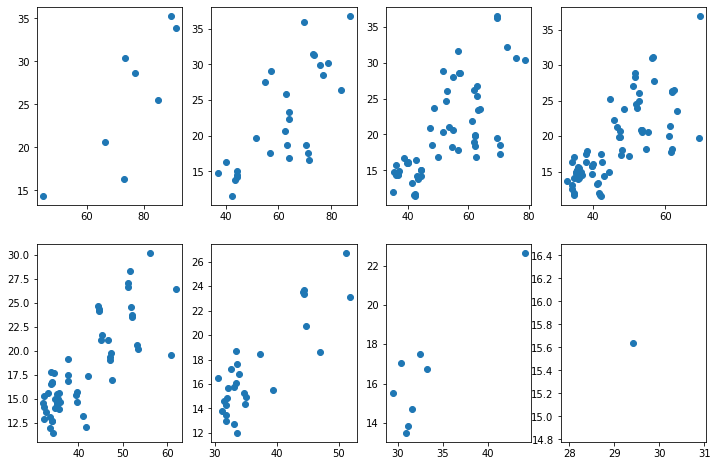

In [24]:
import matplotlib.pyplot as plt

rss_p = np.split(rss, np.cumsum(p_1)[:-1])
err_test_p = np.split(err_test, np.cumsum(p_1)[:-1])
fig = plt.figure(num=1,figsize=(12, 8))
for i in range(p):
    ax = fig.add_subplot(2, 4, i+1)###可从图中看到，我们的画布是分为2x2的区域
    ax.scatter(rss_p[i], err_test_p[i])
plt.show()

In [25]:
Cp = rss + 2 * (d+1) * rss[-1]/(n - p)
AIC = n * np.log(rss) + 2 * (d+1)
print(np.argmin(Cp))
print(np.argmin(AIC))
print(AIC.min())
print(Cp.min())

247
247
242.61159342823868
37.41733678112106


In [26]:
p = 8
n = 100
rho = 0.5
mu = 1
beta = np.array([1, 0]*int(p/2))
z = norm.rvs(size=(n, p))
V = sigma_mat(p, rho)
L = linalg.cholesky(V)
xtrain = np.dot(z, L)
ytrain = mu + np.dot(xtrain, beta) + norm.rvs(size=n)  #训练集

z = norm.rvs(size=(n, p))
xtest = np.dot(z, L)
ytest = mu + np.dot(xtest, beta) + norm.rvs(size=n)  #训练集

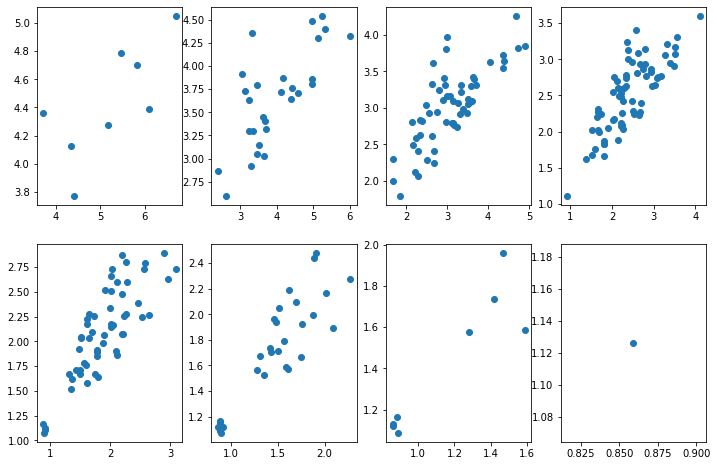

In [27]:
def predict_err(x, y, b):
    b0, b1 = b
    err = y - b0 - np.dot(x, b1)
    return np.inner(err, err)
re_b = [ols(xtrain[:, ind], ytrain) for ind in inds]
err_test = np.array([predict_err(xtest[:, ind], ytest, b_) 
                     for ind, b_ in zip(inds,re_b)])
rss = np.array([predict_err(xtrain[:, ind], ytrain, b_) 
                for ind, b_ in zip(inds,re_b)])
rss_p = np.split(rss, np.cumsum(p_1)[:-1])
err_test_p = np.split(err_test, np.cumsum(p_1)[:-1])
fig = plt.figure(num=1,figsize=(12, 8))
for i in range(p):
    ax = fig.add_subplot(2, 4, i+1)###可从图中看到，我们的画布是分为2x2的区域
    ax.scatter(rss_p[i]/n, err_test_p[i]/n)
plt.show()

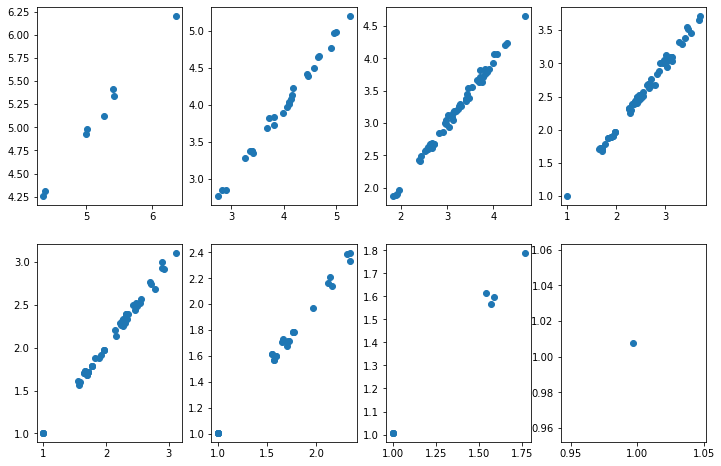

In [28]:
p = 8
n = 10000
rho = 0.5
mu = 1
beta = np.array([1, 0]*int(p/2))
z = norm.rvs(size=(n, p))
V = sigma_mat(p, rho)
L = linalg.cholesky(V)
xtrain = np.dot(z, L)
ytrain = mu + np.dot(xtrain, beta) + norm.rvs(size=n)  #训练集

z = norm.rvs(size=(n, p))
xtest = np.dot(z, L)
ytest = mu + np.dot(xtest, beta) + norm.rvs(size=n)  #训练集

inds_ = [combinations(range(p), i) for i in range(1, p + 1)]
inds_1 = [[list(ind_) for ind_ in ind] for ind in inds_]
p_1 = np.array([len(ind) for ind in inds_1])
inds = [list(ind_) for ind in inds_1 for ind_ in ind]
def predict_err(x, y, b):
    b0, b1 = b
    err = y - b0 - np.dot(x, b1)
    return np.inner(err, err)
re_b = [ols(xtrain[:, ind], ytrain) for ind in inds]
err_test = np.array([predict_err(xtest[:, ind], ytest, b_) 
                     for ind, b_ in zip(inds,re_b)])
rss = np.array([predict_err(xtrain[:, ind], ytrain, b_) 
                for ind, b_ in zip(inds,re_b)])
rss_p = np.split(rss, np.cumsum(p_1)[:-1])
err_test_p = np.split(err_test, np.cumsum(p_1)[:-1])
fig = plt.figure(num=1,figsize=(12, 8))
for i in range(p):
    ax = fig.add_subplot(2, 4, i+1)###可从图中看到，我们的画布是分为2x2的区域
    ax.scatter(rss_p[i]/n, err_test_p[i]/n)
plt.show()

In [32]:
def _solve_pos(xtx, xty):
    mat = linalg.cholesky(xtx)
    return linalg.lapack.dpotrs(mat, xty)[0]

from itertools import combinations, chain
x = np.loadtxt("prostate/x.txt", delimiter=",")
y = np.loadtxt("prostate/y.txt", delimiter=",")
index = np.loadtxt("prostate/index.txt", delimiter=",", dtype=bool)
names = np.loadtxt("prostate/names.txt", delimiter=",", dtype=str)
xtrain, xtest = x[index], x[~index]
ytrain, ytest = y[index], y[~index]

n, p = xtrain.shape
inds_ = [combinations(range(p), i) for i in range(1, p + 1)]
inds_1 = [[list(ind_) for ind_ in ind] for ind in inds_]
p_1 = np.array([len(ind) for ind in inds_1])
inds = [list(ind_) for ind in inds_1 for ind_ in ind]

xtrain_mean = xtrain.mean(axis=0)
xtrain_scale = xtrain - xtrain_mean
ytrain_mean = ytrain.mean()
ytrain_scale = ytrain - ytrain_mean
# xtx = np.dot(xtrain_scale.T, xtrain_scale)
# xty = np.dot(xtrain_scale.T, ytrain_scale)
xtx = np.dot(xtrain.T, xtrain)
xtx_center = xtx - n * np.outer(xtrain_mean, xtrain_mean)
xty = np.dot(xtrain.T, ytrain)
xty_center = xty- n * ytrain_mean * xtrain_mean
re_b_1 = [_solve_pos(xtx_center[np.ix_(ind, ind)], xty_center[ind])
          for ind in inds]
re_b_0 = [ytrain_mean - np.dot(xtrain_mean[ind], b_1_)
          for ind, b_1_ in zip(inds, re_b_1)]
re_b = [(b_0_, b_1_) for b_0_, b_1_ in zip(re_b_0, re_b_1)]

# re_b = [ols(xtrain[:, ind], ytrain) for ind in inds]
err_test = np.array([predict_err(xtest[:, ind], ytest, b_) 
                     for ind, b_ in zip(inds,re_b)])
rss = np.array([predict_err(xtrain[:, ind], ytrain, b_) 
                for ind, b_ in zip(inds,re_b)])
d = np.array(list([len(ind) for ind in inds]))
print(d)
print(names[list(inds[np.argmin(err_test)])])
re_b[np.argmin(err_test)]
xty

[1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 8]
['lcavol' 'svi' 'gleason']


array([  288.4378,   614.2299, 10774.4129,    42.4166,    55.4296,
          19.4296,  1125.3574,  5362.6811])

In [46]:
np.array_split(np.random.permutation(np.arange(6)), 5)

[array([2, 5]), array([3]), array([0]), array([4]), array([1])]

In [47]:
# n = 10
K = 10
np.random.seed(100)
indexs =  np.array_split(np.random.permutation(np.arange(71)), K)
indexs

[array([39, 51, 11, 18, 30, 38, 26, 23]),
 array([40, 50, 20, 45, 70, 41, 66]),
 array([ 5, 28,  0, 12,  6, 54, 60]),
 array([56, 33, 17, 35, 57, 21, 32]),
 array([42, 65, 25, 59, 64, 37, 61]),
 array([47,  7,  3, 58, 46, 55, 19]),
 array([13,  1, 31,  4, 44, 27, 63]),
 array([22, 29,  9, 16, 43, 36, 15]),
 array([69, 68, 49, 62, 14, 34,  2]),
 array([53, 52, 10, 48, 67, 24,  8])]

In [36]:
# def _partial_sum
index = indexs[0]
n_i = np.shape(index)[0]
n_i_ = n - n_i
x_i = xtrain[index, :]
xt_i = x_i.T
y_i = ytrain[index]
x_mean_i = np.mean(x_i, axis=0)
y_mean_i = np.mean(y_i)
xtx_i = np.dot(xt_i, x_i) - n_i * np.outer(x_mean_i, x_mean_i)
xty_i = np.dot(xt_i, y_i) - n_i * y_mean_i * x_mean_i

x_mean_i_ = (n*xtrain_mean - n_i*x_mean_i) / n_i_
y_mean_i_ = (n*ytrain_mean - n_i*y_mean_i) / n_i_
x_mean_i__ = x_mean_i - xtrain_mean
y_mean_i__ = y_mean_i - ytrain_mean
xtx_i_ = xtx - xtx_i - (n_i*n/n_i_) * np.outer(x_mean_i__, x_mean_i__)
xty_i_ = xty - xty_i - (n_i*n/n_i_) * y_mean_i__ * x_mean_i__
b_1_i = _solve_pos(xtx_i_, xty_i_)
b_0_i = y_mean_i_ - np.inner(x_mean_i_, b_1_i)
print(b_0_i, b_1_i)
index_ = np.setdiff1d(np.arange(n), index, assume_unique=False) 
print(ols(xtrain[index_], ytrain[index_]))
b_i = (b_0_i, b_1_i)
cv_err_i = predict_err(x_i, y_i, b_i)
print(b_i)
print(xty_i)
print(y_mean_i__)
print(x_mean_i__)

0.02118318435478672 [ 0.5784  0.6167 -0.0135  0.1254  0.6013 -0.192  -0.02    0.0105]
(1.1026736606555312, array([ 0.5921,  0.539 , -0.0158,  0.1412,  0.5635, -0.1886, -0.1257,
        0.0126]))
(0.02118318435478672, array([ 0.5784,  0.6167, -0.0135,  0.1254,  0.6013, -0.192 , -0.02  ,
        0.0105]))
[  2.5178   1.5283   1.4274   2.888    2.5373  -1.3472   0.9165 -57.8532]
0.12645385778251628
[ 0.3489 -0.1453 -1.3177  0.2334  0.0618 -0.3227 -0.0171  2.3028]


In [38]:
re_b_1_i = [_solve_pos(xtx_i_[np.ix_(ind, ind)], xty_i_[ind]) for ind in inds]
re_b_0_i = [y_mean_i_ - np.inner(x_mean_i_[ind], b_1_i) 
            for ind, b_1_i in zip(inds, re_b_1_i)]
cv_err_i = [predict_err(x_i[:, ind], y_i, (b_0_i, b_1_i))
            for ind, b_0_i, b_1_i in zip(inds, re_b_0_i, re_b_1_i)]
cv_err_i
re_b_0_i




                       

[0.7313928312274287,
 -0.056434749295025455,
 -0.023289016566334197,
 2.4247506220878083,
 1.5922854762514467,
 2.467537094349717,
 -0.030599660038097998,
 0.9886042589218411,
 -0.008730282059208783,
 0.02067513585533698,
 0.7375126108313679,
 0.7342386487435475,
 0.4329646224884325,
 0.022346716638719677,
 0.6316558414305391,
 -0.051275448289528125,
 -0.045311945321821145,
 -0.03891045484174693,
 -0.06049857302388295,
 -0.06094333272830488,
 -0.050043976354977815,
 -0.012053489658975902,
 -0.009773239668509515,
 -0.03025020629136055,
 -0.03444752078559121,
 -0.007191529226158622,
 1.5386722960160497,
 2.458781961111348,
 -0.024571698077668902,
 0.9793052055708327,
 1.1673424812854565,
 -0.006804318618985672,
 0.9840386937073875,
 -0.019735712212246348,
 0.752319270917539,
 0.004852314858917239,
 -0.0025195383838458874,
 0.002053524632767534,
 -0.009522969518982904,
 -0.011458928044682182,
 -0.0055406575246426115,
 -0.012881185945525786,
 0.03052633548690542,
 0.01907560689644905,
 0.0

In [40]:
def cv_err_i_fun(index):
    # index = indexs[0]
    n_i = np.size(index)
    n_i_ = n - n_i
    x_i = xtrain[index, :]
    xt_i = x_i.T
    y_i = ytrain[index]
    x_mean_i = np.mean(x_i, axis=0)
    y_mean_i = np.mean(y_i)
    xtx_i = np.dot(xt_i, x_i) - n_i * np.outer(x_mean_i, x_mean_i)
    xty_i = np.dot(xt_i, y_i) - n_i * y_mean_i * x_mean_i

    x_mean_i_ = (n*xtrain_mean - n_i*x_mean_i) / n_i_
    y_mean_i_ = (n*ytrain_mean - n_i*y_mean_i) / n_i_
    x_mean_i__ = x_mean_i - xtrain_mean
    y_mean_i__ = y_mean_i - ytrain_mean
    xtx_i_ = xtx - xtx_i - (n_i*n/n_i_) * np.outer(x_mean_i__, x_mean_i__)
    xty_i_ = xty - xty_i - (n_i*n/n_i_) * y_mean_i__ * x_mean_i__
    re_b_1_i = [_solve_pos(xtx_i_[np.ix_(ind, ind)], xty_i_[ind]) 
                for ind in inds]
    re_b_0_i = [y_mean_i_ - np.inner(x_mean_i_[ind], b_1_i) 
                for ind, b_1_i in zip(inds, re_b_1_i)]
    cv_err_i = [predict_err(x_i[:, ind], y_i, (b_0_i, b_1_i))
                for ind, b_0_i, b_1_i in zip(inds, re_b_0_i, re_b_1_i)]
    return cv_err_i
cv_err_mat = np.array([cv_err_i_fun(index) for index in indexs])
print(cv_err_mat.shape)
cv_err = cv_err_mat.sum(axis=0) / n
print(names[inds[np.argmin(cv_err)]])
print(cv_err)
# ols(x[]


(10, 255)
['lcavol' 'lweight' 'age' 'lbph' 'svi' 'lcp' 'pgg45']
[1.3373 1.1877 1.3889 1.4481 1.9765 1.3719 1.3179 2.377  0.6069 0.7247
 1.2994 1.3857 1.199  0.7143 1.2966 1.2031 1.2151 0.8575 0.9529 1.1926
 1.0023 1.3938 1.0101 1.1633 1.3822 1.2147 1.8113 1.3011 1.2853 2.2948
 2.6549 1.0028 2.1644 1.1635 2.5523 1.2531 0.5999 0.6006 0.6005 0.6161
 0.6201 0.6063 0.7088 0.7134 0.7349 0.7372 0.7282 1.3196 1.2055 0.6747
 1.2508 1.1153 0.7187 1.3818 0.7204 0.9654 0.734  1.2507 0.8622 0.9575
 1.1959 0.9803 0.8074 0.9346 1.2185 1.0009 0.8816 0.862  0.8407 0.9627
 0.9382 0.9862 0.9233 1.1141 1.3474 1.1942 1.0566 1.0269 1.0109 1.1953
 1.1531 1.3098 2.4748 0.8718 1.9688 1.0768 2.5352 1.2057 1.0538 2.0032
 1.0401 1.1942 0.6006 0.5967 0.6102 0.618  0.5884 0.5703 0.6087 0.6169
 0.5962 0.6    0.6102 0.6139 0.629  0.607  0.6135 0.6652 0.7203 0.6987
 0.7081 0.7031 0.7374 0.7307 0.7498 0.7213 0.7757 1.0731 0.6441 1.32
 0.6889 0.9767 0.694  0.6977 0.8961 0.7409 0.7298 0.8242 0.9534 1.2222
 0.997  0.8824 

$$ Err_{tr}=\frac{1}{n}\sum_{i=1}^n(Y_i-\hat f(X_i))^2=\frac{1}{n}\sum_{i=1}^nr_i^2$$  
$$ Err_{in}=\frac{1}{n}\sum_{i=1}^n E[(Y- \hat f(\vec X))^2 |X, Y, \vec X = X_i] $$
$$ E[Err_{in}|X] = E[Err_{tr}|X] + \frac{2}{n} \sum_{i=1}^n Cov(\hat f (X_i), Y_i|X) $$  
*Proof:*  
$$ Err_{in} - Err_{tr} =\frac {1} {n} \sum_{i=1}^n (E[Y^2| \vec X =X_i] - Y_i^2 - 2(E[Y| \vec X = X_i] - Y_i)\hat f(X_i)) $$
$$ E[Y^2|X, \vec X =X_i]= E[Y_i^2|X] $$
$$ E[Err_{in} -Err_{tr}|X] = - \frac{2}{n} \sum_{i=1}^n E[(E[Y| \vec X = X_i] - Y_i) \hat f(X_i)|X] $$  
$$ E[Y|\vec X= X_i] = E[Y_i|X] $$
$$ E[Y_i - E[Y_i|X] |X] = 0 $$
$$ \begin{split}
E[Err_{in}-Err_{tr}|X] &= \frac{2}{n} \sum_{i=1}^n (E[(Y_i - E[Y|\vec X= X_i]) \hat f(X_i)|X]\\
& \quad - E[Y_i - E[Y_i|X]|X] E[\hat f(X_i)|X])\\
&= \frac{2}{n} \sum_{i=1}^n E[(Y_i-E[Y_i|X])(\hat f(X_i)-E(\hat f(X_i)|X)) |X] \\
&= \frac{2}{n} \sum_{i=1}^n Cov(\hat f(X_i), Y_i|X) 
\end{split}$$  
*Linear Regression:*
$$ E[Err_{in}|X] = \sigma^2 + \frac{1}{n} \sum_{i=1}^n (X_i \beta - E[\hat f(X_i)|X])^2 + \frac{|S|}{n} \sigma^2 $$

$$ \sum_{i=1}^n Cov(\hat f(X_i), Y_i |X) = |S|\sigma^2 $$
*Proof:*
$$ \begin{split}
\sum_{i=1}^n Cov(\hat f(X_i), Y_i) &= \sum_{i=1}^n E[(Y_i-E(Y_i))(\hat f(X_i)-E(\hat f(X_i)))] \\
&= \sum_{i=1}^n E[\epsilon_i X_i^T(X^T X)^{-1}X^T \epsilon] \\
&= \sum_{i=1}^n E[\epsilon_i X_i^T(X^T X)^{-1}X_i \epsilon_i] \\
&= \sigma^2 \sum_{i=1}^n X_i^T(X^T X)^{-1}X_i \\
&= \sigma^2 tr(X^T(X^T X)^{-1}X) \\
&= |S| \sigma^2 
\end{split}$$
  
$$ E[Err_{in}|X] = E[Err_{tr}|X] + \frac{2|S|}{n} \sigma^2 $$  
  
$$ C_p = Err_{tr} + \frac{2|S|}{n} \hat \sigma^2 $$  
  
$$ AIC = \frac{n}{\hat \sigma^2} (Err_{tr} + \frac{2|S|}{n} \hat \sigma^2) $$
$$ BIC = \frac{n}{\hat \sigma^2} (Err_{tr} + \frac{|S|\text{ln}n}{n} \hat \sigma^2) $$  
  
  
*K-fold cross validation:*
$$ Err_{CV} = \frac{1}{K} \sum_{k=1}^K (\frac{1}{n/K} \sum_{i \in A_k}(Y_i - \hat f^{-k}(X_i))^2) $$
  
*Leave-one-out CV:*  
$$ H = X(X^T X)^{-1} X^T , \hat Y = HY $$
$$ Err_{LOOCV}= \frac{1}{n} \sum_{i=1}^n
(\frac {Y_i- \hat Y_i}{1-H_{ii}})^2 $$  



